In [1]:
from IPython.display import Image, SVG
from rdkit import Chem
import json
from rdkit.Chem.Draw import IPythonConsole, ReactionToImage
from rdkit.Chem import AllChem,Draw,Descriptors
import copy
import pandas as pd
import re
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Load Lists

load 10 carbon redox reactions

In [2]:
path_name = 'data_for_Ben/10C_Redox.csv'
redox_rxns = pd.read_csv(path_name)

load kegg reactions

In [3]:
kegg_rxns = pd.read_csv('KEGG_ALL.csv', sep = '\t', engine = 'python')

load kegg canonical smiles dictionary

In [4]:
with open('Kegg_Canonical_Final.json', 'r') as fp:
        Kegg_smiles_dict = json.load(fp)

create kegg canonical smiles list

In [5]:
Kegg_smiles = []
for x in Kegg_smiles_dict:
    Kegg_smiles.append(Kegg_smiles_dict[x])

KEGG reaction list

In [6]:
Kegg_reaction = list(kegg_rxns.EQUATION.values)

In [7]:
kegg_rxns.head()

,DEFINITION,EC_CLASS,EQUATION,KEGG_ID,NAME
0,Polyphosphate + n H2O <=> (n+1) Oligophosphate,3.6.1.10,C00404 + n C00001 <=> (n+1) C02174,R00001,polyphosphate polyphosphohydrolase
1,16 ATP + 16 H2O + 8 Reduced ferredoxin <=> 8 e...,1.18.6.1,16 C00002 + 16 C00001 + 8 C00138 <=> 8 C05359 ...,R00002,Reduced ferredoxin:dinitrogen oxidoreductase (...
2,Diphosphate + H2O <=> 2 Orthophosphate,3.6.1.1,C00013 + C00001 <=> 2 C00009,R00004,diphosphate phosphohydrolase;
3,Urea-1-carboxylate + H2O <=> 2 CO2 + 2 Ammonia,3.5.1.54,C01010 + C00001 <=> 2 C00011 + 2 C00014,R00005,urea-1-carboxylate amidohydrolase
4,2-Acetolactate + CO2 <=> 2 Pyruvate,2.2.1.6,C00900 + C00011 <=> 2 C00022,R00006,pyruvate:pyruvate acetaldehydetransferase (dec...


# Functions

In [8]:
def count_carbons(x):
    smiles = x.Reaction
    
    metabolite = smiles.split('>>')[1]
    
    new_smiles = metabolite.replace('Cl', '')
    numC = new_smiles.count('C') + new_smiles.count('c')
    
    return numC

def same_numC(x):
    reaction = x.Reaction
    
    new_reaction = reaction.replace('Cl', '')
    
    sub = new_reaction.split('>>')[0]
    prod = new_reaction.split('>>')[1]
    
    sub_numC = sub.count('C') + sub.count('c')
    prod_numC = prod.count('C') + prod.count('c')
    
    if sub_numC != prod_numC:
        return False
    
    return True

def same_numN(x):
    reaction = x.Reaction
    
    sub = reaction.split('>>')[0]
    prod = reaction.split('>>')[1]
    
    sub_numN = sub.count('N')
    prod_numN = prod.count('N')
    
    if sub_numN != prod_numN:
        return False
    
    return True

def SmilesToKegg(x):
    rxn = x.Reaction
    
    sub = rxn.split('>>')[0]
    prod = rxn.split('>>')[1]

    # probably substitute with AreTwoMoleculesSame(Chem.MolFromSmiles(lactate_yesCh), 
#                     Chem.MolFromSmiles(lactate_noCh), 
#                     use_chirality = False)
    
    if sub in Kegg_smiles:
        for key in Kegg_smiles_dict:
            if Kegg_smiles_dict[key] == sub:
                kegg_sub = key
                
    else:
        kegg_sub = 'None'
            
    if prod in Kegg_smiles:
        for key in Kegg_smiles_dict:
            if Kegg_smiles_dict[key] == prod:
                kegg_prod = key
    else:
        kegg_prod = 'None'
    
    kegg_rxn = kegg_sub + ' = ' + kegg_prod

    return kegg_rxn

def CompareToKEGG(x):
    rxn = x.Kegg_ID
    
    if rxn != 'None':
        sub = rxn.split(' = ')[0]
        prod = rxn.split(' = ')[1]

        for reaction in Kegg_reaction:
            Kegg_sub = reaction.split('<=>')[0]
            Kegg_prod = reaction.split('<=>')[1]

            #print Kegg_sub, Kegg_prod
            if sub in Kegg_sub and prod in Kegg_prod:
                return reaction

    return 'None'

In [18]:
def AreTwoMoleculesSame(mol_obj1, mol_obj2, use_chirality = False):
    return( mol_obj1.HasSubstructMatch(mol_obj2, useChirality=use_chirality)
           and mol_obj2.HasSubstructMatch(mol_obj1, useChirality=use_chirality))

In [19]:
lactate_noCh = 'CC(O)C(=O)O'
lactate_yesCh = Kegg_smiles_dict['C00186']

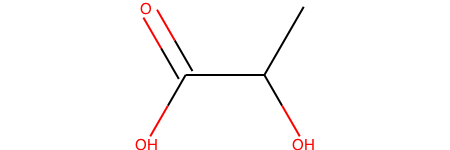

In [20]:
Chem.MolFromSmiles(lactate_noCh)

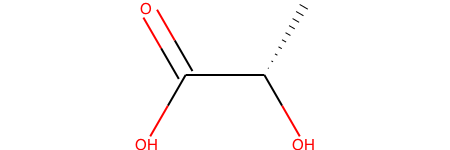

In [21]:
Chem.MolFromSmiles(lactate_yesCh)

In [22]:
AreTwoMoleculesSame(Chem.MolFromSmiles(lactate_yesCh), 
                    Chem.MolFromSmiles(lactate_noCh), 
                    use_chirality = False)

True

In [24]:
AreTwoMoleculesSame(Chem.MolFromSmiles(lactate_yesCh), 
                    Chem.MolFromSmiles(lactate_noCh), 
                    use_chirality = True)

False

# Compare Metabolites to Kegg Metabolites

Get rid of G3 reactions

In [9]:
redox_rxns['Same_NumN'] = redox_rxns.apply(same_numN, 1)

In [10]:
redox_rxns = redox_rxns[redox_rxns.Same_NumN == True]

Count carbons

In [11]:
redox_rxns['numC'] = redox_rxns.apply(count_carbons, 1)

In [12]:
redox_rxns_2C = redox_rxns[redox_rxns.numC == 2]
redox_rxns_3C = redox_rxns[redox_rxns.numC == 3]
redox_rxns_4C = redox_rxns[redox_rxns.numC == 4]

Example dataframe

In [13]:
redox_rxns_2C.head()

,Reaction,Same_NumN,numC
0,CCO>>CC,True,2
7,CSCO>>CSC,True,2
8,OCCF>>CCF,True,2
10,NCCO>>CCN,True,2
11,COCO>>COC,True,2


In [14]:
del redox_rxns_2C['Same_NumN']
del redox_rxns_2C['numC']
del redox_rxns_3C['Same_NumN']
del redox_rxns_3C['numC']
del redox_rxns_4C['Same_NumN']
del redox_rxns_4C['numC']

Convert to csv files

In [15]:
redox_rxns_2C.to_csv('2C_redox_rxns.csv', index = False)
redox_rxns_3C.to_csv('3C_redox_rxns.csv', index = False)
redox_rxns_4C.to_csv('4C_redox_rxns.csv', index = False)

Apply functions to compare to KEGG database

In [24]:
redox_rxns_2C['Kegg_ID'] = redox_rxns_2C.apply(SmilesToKegg, 1)
redox_rxns_2C['KEGG_Rxn'] = redox_rxns_2C.apply(CompareToKEGG, 1)

redox_rxns_3C['Kegg_ID'] = redox_rxns_3C.apply(SmilesToKegg, 1)
redox_rxns_3C['KEGG_Rxn'] = redox_rxns_3C.apply(CompareToKEGG, 1)

redox_rxns_4C['Kegg_ID'] = redox_rxns_4C.apply(SmilesToKegg, 1)
redox_rxns_4C['KEGG_Rxn'] = redox_rxns_4C.apply(CompareToKEGG, 1)

/home/haniu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/haniu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/haniu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

Example dataframe

In [40]:
#if 'None', that means there was no kegg ID associated with the smiles, 
#i.e smiles was generated through reduction/oxidation
redox_rxns_2C

,Reaction,Kegg_ID,KEGG_Rxn
0,CCO>>CC,C00469 = None,None
7,CSCO>>CSC,None = C00580,None
8,OCCF>>CCF,None = None,None
10,NCCO>>CCN,C00189 = C00797,None
11,COCO>>COC,None = C11144,None
12,CNCO>>CNC,None = C00543,None
15,OCCO>>CCO,C15588 = C00469,None
16,OCCS>>CCS,C00928 = None,None
17,CC=O>>CCO,C00084 = C00469,None
20,OCNCO>>CNCO,None = None,None


### 2 Carbon Reactions

In [111]:
redox_rxns_2C[redox_rxns_2C.KEGG_Rxn != 'None']

,Reaction,Kegg_ID,KEGG_Rxn
7579,O=CCS(=O)(=O)O>>O=S(=O)(O)CCO,C00593 = C05123,C00593 + C00005 + C00080 <=> C05123 + C00006


### 3 Carbon Reactions

In [112]:
redox_rxns_3C[redox_rxns_3C.KEGG_Rxn != 'None']

,Reaction,Kegg_ID,KEGG_Rxn
134,CC(C)=O>>CC(C)O,C00207 = C01845,C00207 + C00005 + C00080 <=> C01845 + C00006
289,C#CC(=O)O>>C#CC=O,C00804 = C05985,C01359 + C00804 <=> C05985 + C00113 + C00001
483,CC(=O)C=O>>CC(=O)CO,C00546 = C05235,C00546 + C00005 + C00080 <=> C05235 + C00006
2240,O=C[C@@H](O)CO>>OCC(O)CO,C02426 = C00116,C02426 + C00005 + C00080 <=> C00116 + C00006


### 4 Carbon Reactions

In [105]:
redox_rxns_4C[redox_rxns_4C.KEGG_Rxn != 'None']

,Reaction,Kegg_ID,KEGG_Rxn
81,CCCC=O>>CCCCO,C01412 = C06142,C01412 + C00004 + C00080 <=> C06142 + C00003
6799,CC(=O)C(C)=O>>CC(=O)[C@H](C)O,C00741 = C01769,C00741 + C00004 + C00080 <=> C01769 + C00003
34444,CC(C(=O)O)C(=O)O>>C[C@@H](C=O)C(=O)O,C02170 = C06002,C02170 + C00027 <=> C06002 + C00007 + C00001
40835,O=C(O)C[C@H](O)C(=O)O>>O=C(O)CCC(=O)O,C00149 = C00042,C00091 + C00149 <=> C00042 + C04348
47229,O=C(O)C[C@@H](O)C(=O)O>>O=C(O)CCC(=O)O,C00497 = C00042,C00091 + C00497 <=> C00042 + C20747
70278,O=C(O)CC(=O)C(=O)O>>O=C(O)C[C@H](O)C(=O)O,C00036 = C00149,C00186 + C00036 <=> C00149 + C00022


In [113]:
for rxn in rxn_list_4C[2000:2100]:
    print rxn
    display(AllChem.ReactionFromSmarts(str(rxn)))

O=CC(O)C(O)C(O)(P(=O)(O)O)P(=O)(O)O>>O=CCC(O)C(O)(P(=O)(O)O)P(=O)(O)O


NameError: name 'display' is not defined

# Comparing the 7 carbon lists

Load 7 carbon redox lists

In [106]:
G1_7C = pd.read_csv('~/Dropbox/Quantum/redox/final_lists/Non_Measured/G1_Filtered__7C.tsv', sep = '\t', )
G2_7C = pd.read_csv('~/Dropbox/Quantum/redox/final_lists/Non_Measured/G2_Filtered__7C.tsv', sep = '\t', )
G3_7C = pd.read_csv('~/Dropbox/Quantum/redox/final_lists/Non_Measured/G3_Filtered__7C.tsv', sep = '\t', )
G4_7C = pd.read_csv('~/Dropbox/Quantum/redox/final_lists/Non_Measured/G4_Filtered__7C.tsv', sep = '\t', )

In [93]:
G1_7C_keggID = list(G1_7C.Reaction.values)
G2_7C_keggID = list(G2_7C.Reaction.values)
G3_7C_keggID = list(G3_7C.Reaction.values)
G4_7C_keggID = list(G4_7C.Reaction.values)
G1_7C_rxn = list(G1_7C.RXN_smarts.values)
G2_7C_rxn = list(G2_7C.RXN_smarts.values)
G3_7C_rxn = list(G3_7C.RXN_smarts.values)
G4_7C_rxn = list(G4_7C.RXN_smarts.values)

In [98]:
G1_7C_df = pd.DataFrame(G1_7C_keggID, columns = ['Kegg_ID'])
G2_7C_df = pd.DataFrame(G2_7C_keggID, columns = ['Kegg_ID'])
G3_7C_df = pd.DataFrame(G3_7C_keggID, columns = ['Kegg_ID'])
G4_7C_df = pd.DataFrame(G4_7C_keggID, columns = ['Kegg_ID'])
G1_7C_df['Reaction'] = G1_7C_rxn
G2_7C_df['Reaction'] = G2_7C_rxn
G3_7C_df['Reaction'] = G3_7C_rxn
G4_7C_df['Reaction'] = G4_7C_rxn

In [100]:
G1_7C_df['KEGG_Rxn'] = G1_7C_df.apply(CompareToKEGG, 1)
G2_7C_df['KEGG_Rxn'] = G2_7C_df.apply(CompareToKEGG, 1)
G3_7C_df['KEGG_Rxn'] = G3_7C_df.apply(CompareToKEGG, 1)
G4_7C_df['KEGG_Rxn'] = G4_7C_df.apply(CompareToKEGG, 1)

### G1 Reactions

In [107]:
G1_7C_df[G1_7C_df.KEGG_Rxn != 'None']

,Kegg_ID,Reaction,KEGG_Rxn
19,C00804 = C05985,C(=O)(C#C)O>>C(#C)C=O,C01359 + C00804 <=> C05985 + C00113 + C00001
30,C02170 = C06002,C(C(=O)O)(C(=O)O)C>>[C@@H](C(=O)O)(C=O)C,C02170 + C00027 <=> C06002 + C00007 + C00001
45,C05947 = C05938,[C@@H](C(=O)O)(C[C@H](C(=O)O)O)N>>C([C@@H](C(=...,C05947 + C00004 + C00080 <=> C05938 + C00003 +...
76,C00628 = C05585,c1(c(ccc(c1)O)O)C(=O)O>>c1c(ccc(c1C=O)O)O,C00628 + C00027 <=> C05585 + C00007 + C00001
81,C00156 = C00633,c1(C(=O)O)ccc(cc1)O>>c1(ccc(cc1)O)C=O,C00156 + C00028 + C00001 <=> C00633 + C00030 +...


### G2 Reactions

In [108]:
G2_7C_df[G2_7C_df.KEGG_Rxn != 'None']

,Kegg_ID,Reaction,KEGG_Rxn
0,C00067 = C00132,C=O>>CO,2 C00067 + C00001 <=> C00058 + C00132
3,C00593 = C05123,C(S(=O)(=O)O)C=O>>C(S(=O)(=O)O)CO,C00593 + C00005 + C00080 <=> C05123 + C00006
14,C00207 = C01845,C(=O)(C)C>>C(C)(C)O,C00207 + C00005 + C00080 <=> C01845 + C00006
25,C00546 = C05235,C(=O)(C=O)C>>C(=O)(CO)C,C00546 + C00005 + C00080 <=> C05235 + C00006
40,C06753 = C06754,C(CCl)O>>C(=O)CCl,C06753 + 2 C00125 <=> C06754 + 2 C00126 + 2 C0...
41,C05986 = C05985,C(#C)CO>>C(#C)C=O,C05986 + 2 C00125 <=> C05985 + 2 C00126 + 2 C0...
43,C02426 = C00116,[C@H](CO)(C=O)O>>C(CO)(CO)O,C02426 + C00005 + C00080 <=> C00116 + C00006
47,C01412 = C06142,C(CC)C=O>>C(CC)CO,C01412 + C00004 + C00080 <=> C06142 + C00003
51,C00036 = C00149,OC(=O)CC(=O)C(=O)O>>[C@H](CC(=O)O)(C(=O)O)O,C00186 + C00036 <=> C00149 + C00022
53,C00741 = C01769,C(=O)(C(=O)C)C>>CC(=O)[C@H](C)O,C00741 + C00004 + C00080 <=> C01769 + C00003


### G3 Reactions

In [109]:
G3_7C_df[G3_7C_df.KEGG_Rxn != 'None']

,Kegg_ID,Reaction,KEGG_Rxn
5,C00048 = C00037,C(=O)(C=O)O>>C(=O)(CN)O,C00041 + C00048 <=> C00022 + C00037
15,C00022 = C00041,CC(=O)C(=O)O>>OC(=O)[C@H](C)N,C00047 + C00022 <=> C04076 + C00041
18,C00022 = C00133,CC(=O)C(=O)O>>OC(=O)[C@@H](C)N,C00647 + C00022 <=> C00018 + C00133
19,C02798 = C05672,C(C(=O)C(=O)O)P(=O)(O)O>>OC(=O)C(CP(=O)(O)O)N,C02798 + C00025 <=> C05672 + C00026
23,C00222 = C00099,C(C(=O)O)C=O>>C(C(=O)O)CN,C00041 + C00222 <=> C00022 + C00099
28,C00036 = C00049,OC(=O)CC(=O)C(=O)O>>OC(=O)[C@H](CC(=O)O)N,C00037 + C00036 <=> C00048 + C00049
30,C00441 = C03283,OC(=O)[C@H](CC=O)N>>[C@H](CCN)(C(=O)O)N,C00025 + C00441 <=> C00026 + C03283
39,C06002 = C03284,[C@@H](C(=O)O)(C=O)C>>[C@@H](C(=O)O)(CN)C,C00041 + C06002 <=> C00022 + C03284
54,C00026 = C00217,C(=O)(CCC(=O)O)C(=O)O>>[C@@H](CCC(=O)O)(C(=O)O)N,C00133 + C00026 <=> C00022 + C00217
56,C01180 = C00073,C(=O)(C(=O)O)CCSC>>[C@@H](C(=O)O)(CCSC)N,C01180 + C00025 <=> C00073 + C00026


### G4 Reactions

In [110]:
G4_7C_df[G4_7C_df.KEGG_Rxn != 'None']

,Kegg_ID,Reaction,KEGG_Rxn
38,C00065 = C00041,[C@@H](C(=O)O)(CO)N>>OC(=O)[C@H](C)N,C00065 + C00022 <=> C00168 + C00041
40,C00497 = C00042,[C@@H](CC(=O)O)(C(=O)O)O>>OC(=O)CCC(=O)O,C00091 + C00497 <=> C00042 + C20747
46,C00149 = C00042,[C@H](CC(=O)O)(C(=O)O)O>>OC(=O)CCC(=O)O,C00091 + C00149 <=> C00042 + C04348
84,C03079 = C00025,OC(=O)C(C[C@@H](C(=O)O)N)O>>[C@H](CCC(=O)O)(C(...,C03079 + C00026 <=> C01127 + C00025
153,C03743 = C02183,c1(c(cc(cc1O)O)O)O>>c1(cc(cc(c1)O)O)O,C03743 + C01108 <=> C03743 + C02183
165,C07103 = C00472,C1(=CC(=O)C=CC1=O)O>>C1(=O)C=CC(=O)C=C1,C07103 <=> C00472 + C00001
204,C00318 = C01181,C([N+](C)(C)C)[C@@H](CC(=O)[O-])O>>[N+](CCCC(=...,C20749 + C00318 <=> C01181 + C20750
230,C00556 = C01455,c1(ccccc1)CO>>c1(ccccc1)C,C00556 + C00139 + C00001 <=> C01455 + C00007 +...
